### **Sources**



[Attention-based CNN-LSTM and XGBoost hybrid model for stock prediction](https://paperswithcode.com/paper/attention-based-cnn-lstm-and-xgboost-hybrid)


[Predicting Stock Market Time-Series Data using CNN-LSTM Neural Network Model](https://paperswithcode.com/paper/predicting-stock-market-time-series-data)

### **Imports**

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", module="statsmodels")

### **Introduction**

In this project, we explored various machine learning techniques to predict stock prices using historical data from Yahoo Finance. We started by building two types of neural network models: a Convolutional Neural Network (CNN) and a CNN combined with Long Short-Term Memory (LSTM) networks. The CNN model focuses on detecting patterns in stock prices, while the CNN-LSTM model aims to understand both short-term and long-term trends. We also integrated ARIMA, a statistical method, with XGBoost, a powerful machine learning model, to refine our predictions. By comparing the performance of these models, we aimed to improve our ability to forecast stock prices and gain insights into which approach works best for this task.


The models we've chosen fit the stock price prediction problem by leveraging their strengths in handling different aspects of time-series data.

1. **Convolutional Neural Network (CNN):** CNNs are excellent at detecting patterns and trends in data. In the context of stock price prediction, they can identify important features from historical price data, such as recurring patterns or anomalies.

2. **CNN-LSTM Model:** This hybrid model combines the pattern recognition capability of CNNs with the sequence-learning power of LSTMs. The CNN layers extract features from the data, while the LSTM layers capture the temporal dependencies and trends over time. This combination could be useful for predicting stock prices because it can learn both the spatial features and temporal dynamics of the data.

3. **ARIMA and XGBoost Integration:** ARIMA models are effective for capturing linear trends and seasonality in time-series data, while XGBoost is a powerful machine learning model that can handle complex, non-linear relationships. Combining these models allows us to capture both linear and non-linear patterns, improving prediction accuracy.

For training these models, we'll use the Mean Squared Error (MSE) loss function. MSE measures the average squared difference between the predicted and actual values. It's a suitable choice because it penalizes larger errors more heavily, which is important in stock price prediction where accurate forecasting is crucial. By minimizing the MSE, the models will be optimized to make predictions as close to the actual stock prices as possible.

We also use MAE (Mean Absolute Error) and $R^2$ measures to evaluate prediction accuracy.






###**The next steps:**






1. **Data Collection:**
   - `download_stock_data(ticker, start, end)`: Downloads historical stock data using Yahoo Finance.

2. **Data Preprocessing:**
   - `preprocess_data(stock_data)`: Scales the data and prepares it for modeling by creating sequences of 60 days of stock prices for input features.

3. **CNN Model:**
   - `build_cnn_model(input_shape)`: Builds a Convolutional Neural Network (CNN) for predicting stock prices based on the patterns detected in the last 60 days of stock prices.

4. **CNN-LSTM Model:**
   - `build_cnn_lstm_model(input_shape)`: Builds a CNN-LSTM model to capture both short-term patterns (using CNN) and long-term trends (using LSTM).

5. **Training and Evaluation:**
   - `train_and_evaluate_model(model, X_train, y_train, X_test, y_test, scaler, model_name)`: Trains the model and evaluates its performance, plotting loss curves and predictions versus actual stock prices.

6. **ARIMA + XGBoost:**
   - `apply_arima(stock_data, order=(2, 0, 1))`: Fits an ARIMA model to stock prices to get residuals.
   - `build_xgboost_model(X_train, y_train, X_test, y_test)`: Trains an XGBoost model on the residuals to refine the predictions.

7. **Feature Importances:**
   - Extracts and plots feature importances from the XGBoost model to understand which days are more influential in predicting the stock price.

8. **CNN Improvement with ARIMA Residuals:**
   - Preprocesses residuals and applies them to improve CNN model predictions by incorporating the residuals from the ARIMA model.


### **Data Collection**

In [ ]:
# Step 1: Download the data
def download_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

# Step 2: Data Preprocessing
def preprocess_data(stock_data):
    data = stock_data[['Close']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(60, len(scaled_data)):
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler


### **CNN Model**

In [ ]:

# Step 3: CNN Model
def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Use Input layer instead of passing input_shape to Conv1D
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



### **CNN Model (Convolutional Neural Network)**:
1. **Input**: stock prices for the past 60 days (called a "window").
2. **Convolution**: The CNN layer applies filters to the data to detect patterns, such as price trends or fluctuations, scanning through the stock prices to spot interesting movements.
3. **Pooling**: The MaxPooling layer reduces the amount of information by focusing only on the most important parts of the detected patterns. It helps simplify the data so the model can focus on the key trends.
4. **Flattening**: This takes the simplified information from the previous layers and converts it into a flat list so that the model can process it.
5. **Dense Layers**: Finally, the Dense layers act like decision-makers. They take the learned patterns and try to predict the next day's stock price based on the information from the previous 60 days.
   
   **Goal**: The CNN model looks at 60 days of stock prices, finds patterns, and uses them to predict the next day’s price.


### **CNN-LSTM Model**

In [ ]:

# Step 4: CNN-LSTM Model
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model



1. **Input**: This model also looks at the last 60 days of stock prices, but it processes them in a more complex way.
2. **TimeDistributed CNN**: The CNN layer is applied at each time step (each day) of the 60-day window. This step helps detect short-term patterns in stock prices (like daily trends or sudden jumps).
3. **LSTM Layers**: After detecting patterns, the LSTM layers help the model understand the sequence of stock prices over time. LSTMs are good at remembering what happened earlier, so they help the model understand the flow of stock prices across the 60 days and how each day might affect the next.
4. **Dropout**: This randomly ignores some parts of the data during training to make the model more general and avoid overfitting (so it doesn’t memorize the data but learns to generalize).
5. **Dense Layers**: Finally, the Dense layers combine the patterns and time relationships learned to predict the stock price for the next day.

   **Goal**: The CNN-LSTM model detects both short-term patterns and long-term trends in stock prices and uses them to predict the next day's price more effectively. It should be more powerful because it understands the sequence and not just the patterns.

### **Training and Evaluation**

In [ ]:

# Step 5: Train and Evaluate the Model (with 1x2 subplot)
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, scaler, model_name):
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    end_time = time.time()
    training_time = end_time - start_time

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_scaled, predictions)
    mae = mean_absolute_error(y_test_scaled, predictions)
    r2 = r2_score(y_test_scaled, predictions)

    # Create a 1x2 subplot for both loss and prediction
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    # Subplot 1: Training & validation loss
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Test Loss')
    axs[0].set_title(f'{model_name} Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Subplot 2: Predictions vs actual stock prices
    axs[1].plot(y_test_scaled, color='blue', label='Actual Stock Price')
    axs[1].plot(predictions, color='red', label='Predicted Stock Price')
    axs[1].set_title(f'{model_name} Stock Price Prediction')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Stock Price')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Print model performance
    print("")
    print(f'{model_name} Model Performance:')
    print(f'Training Time: {training_time:.2f} seconds')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R^2 Score: {r2}')

    return mse, mae, r2, predictions


#### **Apple stock example**

In [ ]:
# Example Usage
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2020-12-31'

stock_data = download_stock_data(ticker, start_date, end_date)
X, y, scaler = preprocess_data(stock_data)

# Splitting the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


[*********************100%***********************]  1 of 1 completed


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


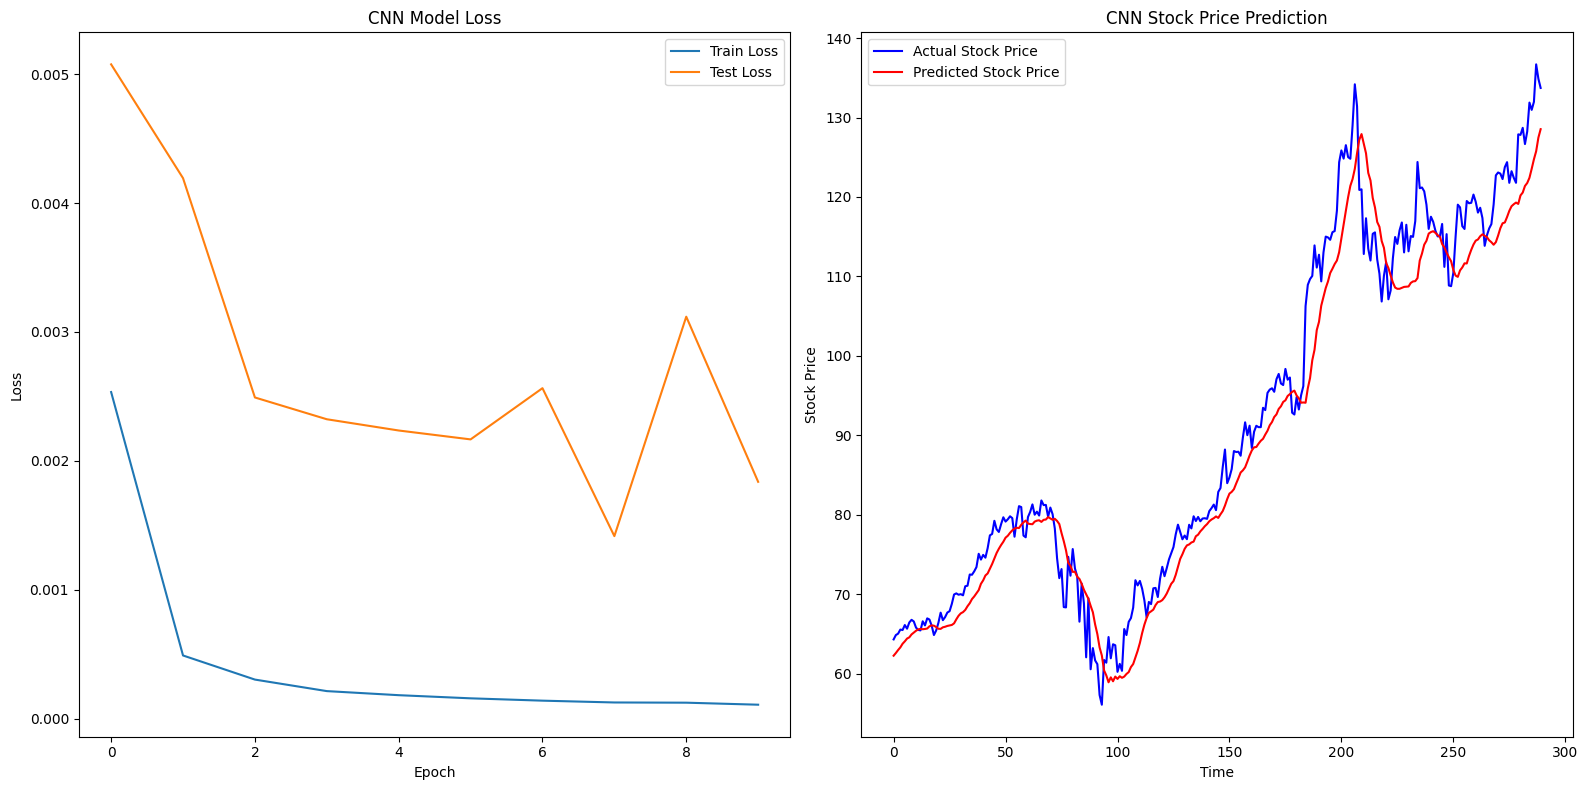


CNN Model Performance:
Training Time: 5.34 seconds
Mean Squared Error: 23.917942959151947
Mean Absolute Error: 3.9294264563198746
R^2 Score: 0.9517371358078346


In [ ]:
# Build and Train the CNN model
cnn_model = build_cnn_model((X_train.shape[1], 1))
cnn_mse, cnn_mae, cnn_r2, cnn_predictions = train_and_evaluate_model(cnn_model, X_train, y_train, X_test, y_test, scaler, 'CNN')


The predicted stock price closely follows the actual stock price, especially during less volatile periods. However, during times of rapid price changes, the prediction lags or deviates slightly.

The training loss decreases consistently over the epochs, suggesting that the model is learning. However, the validation/test loss shows significant fluctuations, indicating overfitting or that the model may not generalize well to unseen data.


### **CNN -  CI Bootstrap Estimates**

In [ ]:
from sklearn.utils import resample

# Define a function to calculate bootstrap confidence intervals
def bootstrap_ci(model_predictions, actual_values, scaler, n_iterations=1000, ci_level=95):
    mse_bootstrap = []
    r2_bootstrap = []

    # Rescale actual values to their original form
    actual_values_scaled = scaler.inverse_transform(actual_values.reshape(-1, 1)).flatten()

    # Bootstrap iterations
    for i in range(n_iterations):
        # Resample with replacement
        actual_resampled, pred_resampled = resample(actual_values_scaled, model_predictions)

        # Calculate MSE and R² for resampled data
        mse = mean_squared_error(actual_resampled, pred_resampled)
        r2 = r2_score(actual_resampled, pred_resampled)

        # Store results
        mse_bootstrap.append(mse)
        r2_bootstrap.append(r2)

    # Calculate confidence intervals
    lower_mse = np.percentile(mse_bootstrap, (100 - ci_level) / 2)
    upper_mse = np.percentile(mse_bootstrap, 100 - (100 - ci_level) / 2)

    lower_r2 = np.percentile(r2_bootstrap, (100 - ci_level) / 2)
    upper_r2 = np.percentile(r2_bootstrap, 100 - (100 - ci_level) / 2)

    return (lower_mse, upper_mse), (lower_r2, upper_r2)

# Calculate confidence intervals for CNN model
cnn_mse_ci, cnn_r2_ci = bootstrap_ci(cnn_predictions.flatten(), y_test, scaler)

print(f'CNN Model MSE Confidence Interval: {cnn_mse_ci}')
print(f'CNN Model R² Confidence Interval: {cnn_r2_ci}')


CNN Model MSE Confidence Interval: (20.241935253627535, 27.600175350438878)
CNN Model R² Confidence Interval: (0.9439498073730684, 0.9579266965600785)


CI for MSE ans $R^2$ shows the intervals in which we can expect the values to fall in 0.95 probability of coverage. We can see our values fall within the interval.

### **CNN-LSTM model**

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step


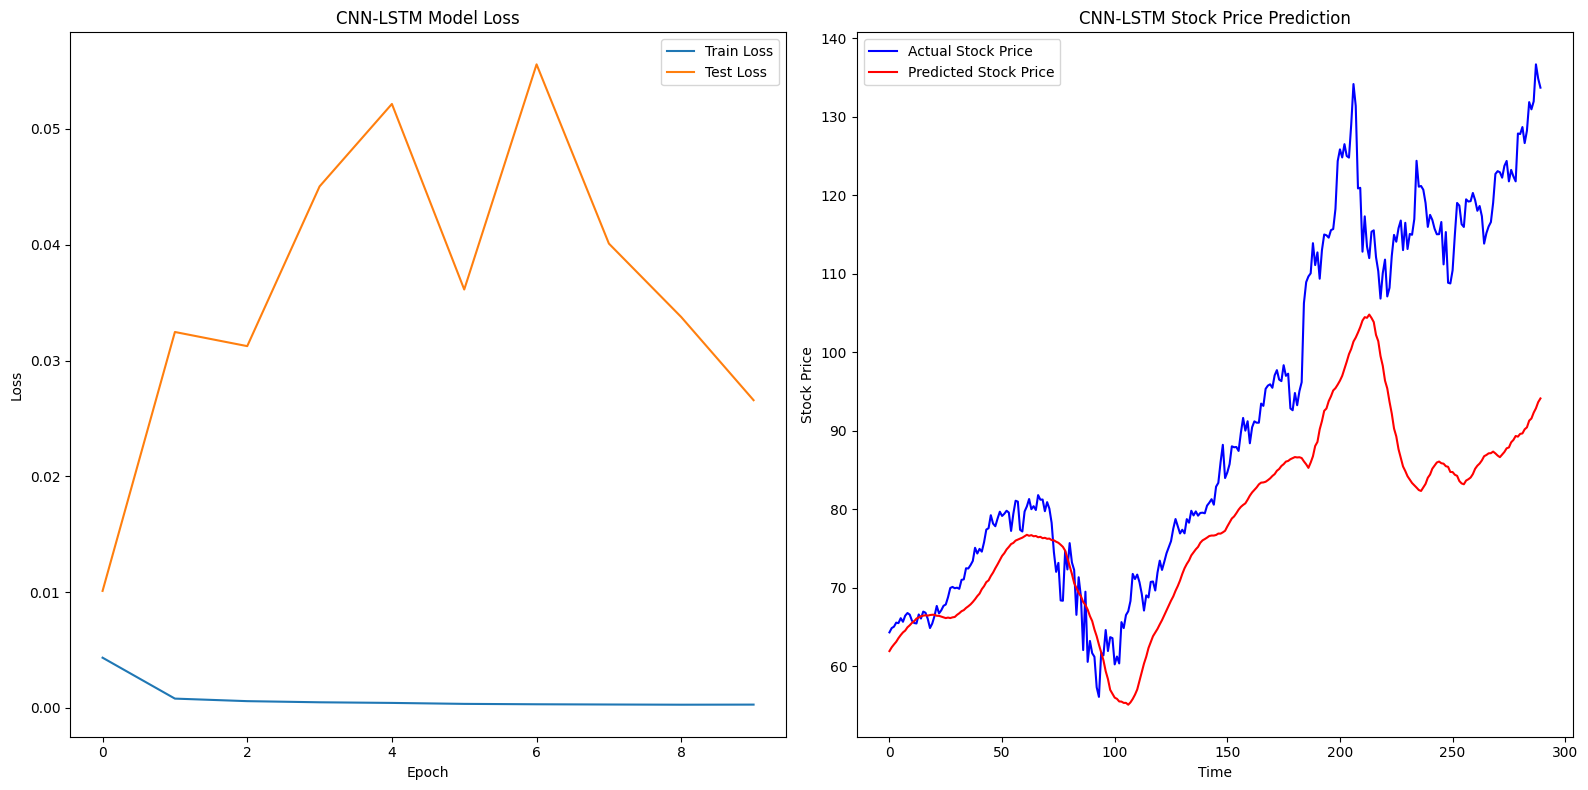


CNN-LSTM Model Performance:
Training Time: 17.42 seconds
Mean Squared Error: 346.039776731052
Mean Absolute Error: 13.854930561986462
R^2 Score: 0.3017430145234302


In [ ]:
# Reshape data for CNN-LSTM model (Adding extra dimension for TimeDistributed)
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1], 1))

# Build and Train the CNN-LSTM model
cnn_lstm_model = build_cnn_lstm_model((1, X_train.shape[1], 1))
cnn_lstm_mse, cnn_lstm_mae, cnn_lstm_r2, cnn_lstm_predictions = train_and_evaluate_model(cnn_lstm_model, X_train_lstm, y_train, X_test_lstm, y_test, scaler,'CNN-LSTM')

The CNN-LSTM model seems to be underfitting the actual stock price. Despite being highly complex, the model is producing smoothed predictions that miss critical peaks and valleys of the actual data. This suggests the model architecture might be over-simplified for capturing complex stock price movements.

### **CNN-LSTM - CI Bootstrap Estimates**

In [ ]:

# Calculate confidence intervals for CNN-LSTM model
cnn_lstm_mse_ci, cnn_lstm_r2_ci = bootstrap_ci(cnn_lstm_predictions.flatten(), y_test, scaler)

print(f'CNN-LSTM Model MSE Confidence Interval: {cnn_lstm_mse_ci}')
print(f'CNN-LSTM Model R² Confidence Interval: {cnn_lstm_r2_ci}')


CNN-LSTM Model MSE Confidence Interval: (292.31167062516136, 399.8212235239103)
CNN-LSTM Model R² Confidence Interval: (0.21237541177999397, 0.382252929592568)


Once again our CI including the values we got before. But still, the CNN-LSTM performence are not good for our problem as the regular CNN model.

### **Arima + XGboost Residuals Prediction**

ARIMA (AutoRegressive Integrated Moving Average) is used to capture linear patterns and trends in the stock price data.
We fit an ARIMA model to the 'Close' prices of the stock data. This model helps in understanding the underlying linear dynamics and residuals (the differences between the actual prices and the values predicted by ARIMA).

For the original stock data, We scale it and prepare it for training.
After applying ARIMA, We use the residuals (errors from ARIMA predictions) to train a separate model. The residuals are expected to capture patterns that ARIMA couldn't model.

XGBoost (Extreme Gradient Boosting) is a powerful machine learning model that can capture complex, non-linear relationships in the data.
We use XGBoost to predict the residuals from the ARIMA model. This helps refine the forecast by correcting the ARIMA model’s predictions with XGBoost.


After obtaining the residuals from the ARIMA model, We preprocess these residuals and train an XGBoost model on them.
We then use the trained XGBoost model to predict residuals, which We can combine with the ARIMA predictions to get an improved forecast.


The article suggests that traditional ARIMA models struggle with capturing non-linearities in stock price predictions. To overcome this, the proposed model integrates ARIMA with deep learning techniques (CNN) and XGBoost. The CNN model extracts deep features from the stock data, while XGBoost fine-tunes the predictions. Our approach aligns with this by using ARIMA for initial linear modeling and XGBoost for refining the predictions based on residuals.

[*********************100%***********************]  1 of 1 completed


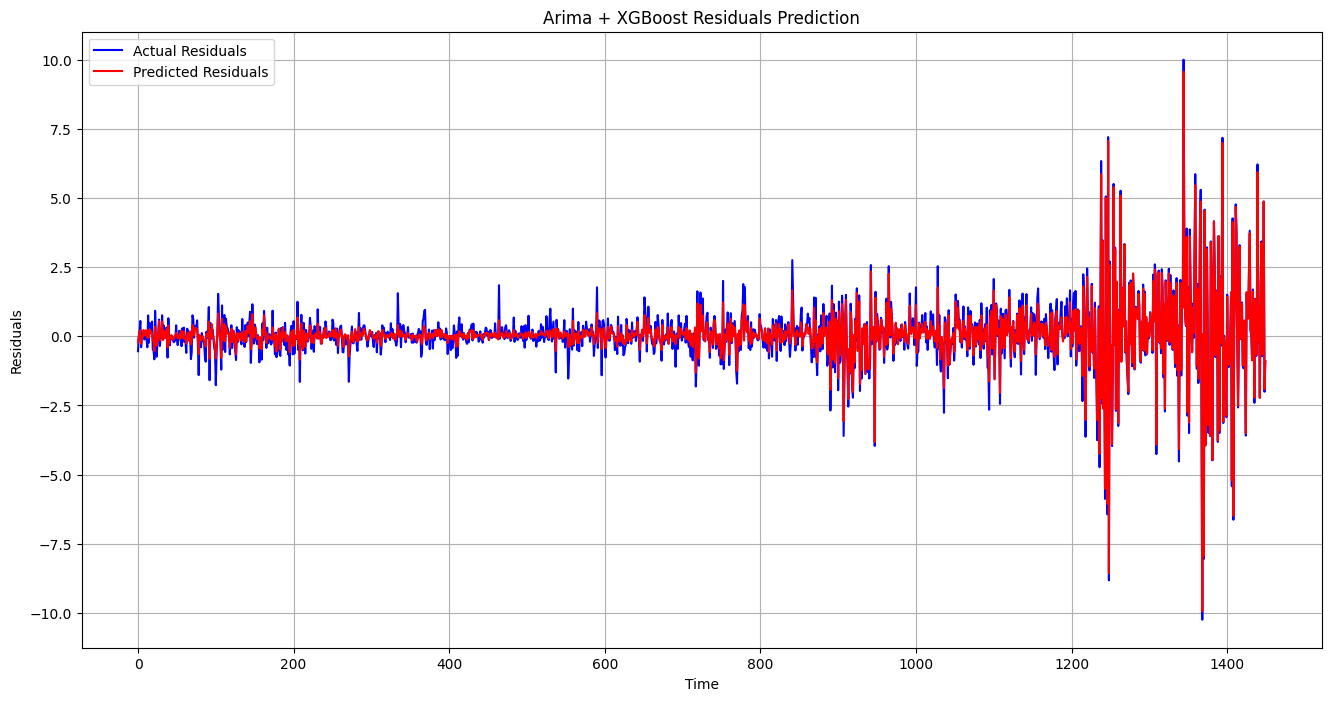


Model Performance:
Mean Squared Error: 0.059385933362400736
Mean Absolute Error: 0.1769423064377197
R^2 Score: 0.9604460404514115


In [ ]:


def apply_arima(stock_data, order=(2, 0, 1)):
    model = ARIMA(stock_data['Close'], order=order)
    arima_result = model.fit()
    # Output fitted values and residuals
    fitted_values = arima_result.fittedvalues
    residuals = arima_result.resid
    return fitted_values, residuals



def preprocess_data(data, is_residuals=False):
    if is_residuals:
        # If the data contains residuals, we don't need 'Close' column
        X, y = [], []
        for i in range(60, len(data)):
            X.append(data[i-60:i].values)  # Access values directly
            y.append(data.iloc[i].values)  # Access values directly
        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    else:
        # If the data is stock data
        data = data[['Close']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)

        X, y = [], []
        for i in range(60, len(scaled_data)):
            X.append(scaled_data[i-60:i, 0])
            y.append(scaled_data[i, 0])

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, y, scaler

    return X, y



# Step 7: XGBoost Model
def build_xgboost_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)

    # Predicting stock prices
    predictions = model.predict(X_test)
    return predictions, model

# Example Usage: Integrating ARIMA and XGBoost
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2020-12-31'

stock_data = download_stock_data(ticker, start_date, end_date)
X, y, scaler = preprocess_data(stock_data)

fitted_values, residuals = apply_arima(stock_data)

# Convert residuals to DataFrame for preprocessing
residuals_df = pd.DataFrame(residuals, columns=['Residuals'])
X_res, y_res = preprocess_data(residuals_df, is_residuals=True)

# Reshape X_res for XGBoost
X_res_2d = X_res.reshape((X_res.shape[0], -1))

# Build and train the XGBoost model
xgboost_predictions, xgboost_model = build_xgboost_model(X_res_2d, y_res, X_res_2d, y_res)

# Plot results
plt.figure(figsize=(16, 8))
plt.plot(y_res, color='blue', label='Actual Residuals')
plt.plot(xgboost_predictions, color='red', label='Predicted Residuals')
plt.title('Arima + XGBoost Residuals Prediction')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the XGBoost model
print("")
print('Model Performance:')
print(f'Mean Squared Error: {mean_squared_error(y_res, xgboost_predictions)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_res, xgboost_predictions)}')
print(f'R^2 Score: {r2_score(y_res, xgboost_predictions)}')




The graph displays the results of an ARIMA + XGBoost model integration, where we used ARIMA to model the stock price residuals and XGBoost to predict the residuals.


From the graph, it looks like the model is able to capture the general trend of residuals. The residuals predicted by XGBoost align well with the actual residuals.

The performance starts to degrade slightly in more volatile regions where the residuals fluctuate heavily. This might suggest that the model could be improved, possibly by tuning hyperparameters or by better feature engineering.

### **XGboost feature importance**

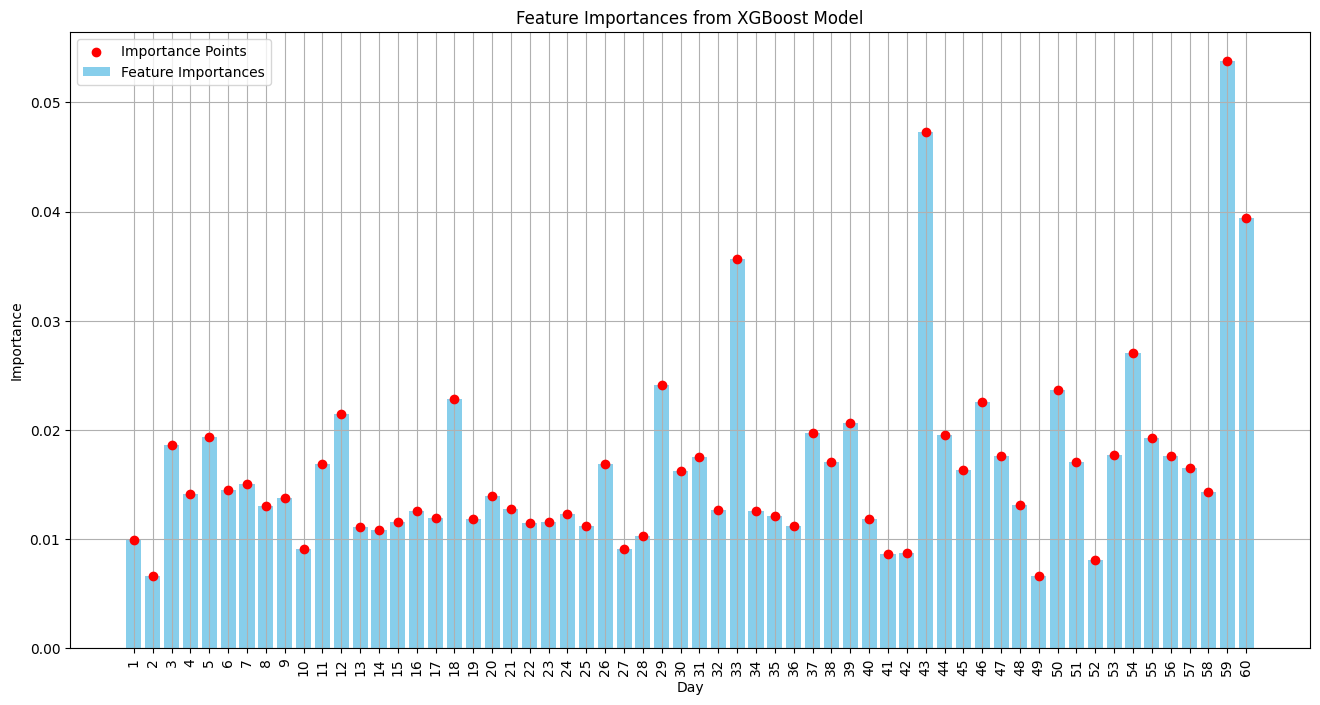

In [ ]:

# Extract feature importances
importances = xgboost_model.feature_importances_

# Create an array of feature indices (representing days)
num_features = X_train.shape[1]
days = np.arange(1, num_features + 1)

# Sort by feature index (for display purposes)
sorted_indices = np.argsort(days)

# Prepare data for plotting
sorted_days = days[sorted_indices]
sorted_importances = importances[sorted_indices]

# Plot the feature importances with a bar chart and scatter plot
plt.figure(figsize=(16, 8))
plt.title('Feature Importances from XGBoost Model')
plt.bar(sorted_days, sorted_importances, align='center', label='Feature Importances', color='skyblue')
plt.scatter(sorted_days, sorted_importances, color='red', label='Importance Points', zorder=5)
plt.xticks(sorted_days, rotation=90)
plt.xlabel('Day')
plt.ylabel('Importance')
plt.legend()
plt.grid(True)
plt.show()


We can see the importance of days increases toward the end of train day value (day 59 is the most important feature). We can say that there is a positive correlation between day number and its importance as feature to predict the 61 day from the previous 60 days.

### **CNN Improvment with ARIMA residuals**

[*********************100%***********************]  1 of 1 completed


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


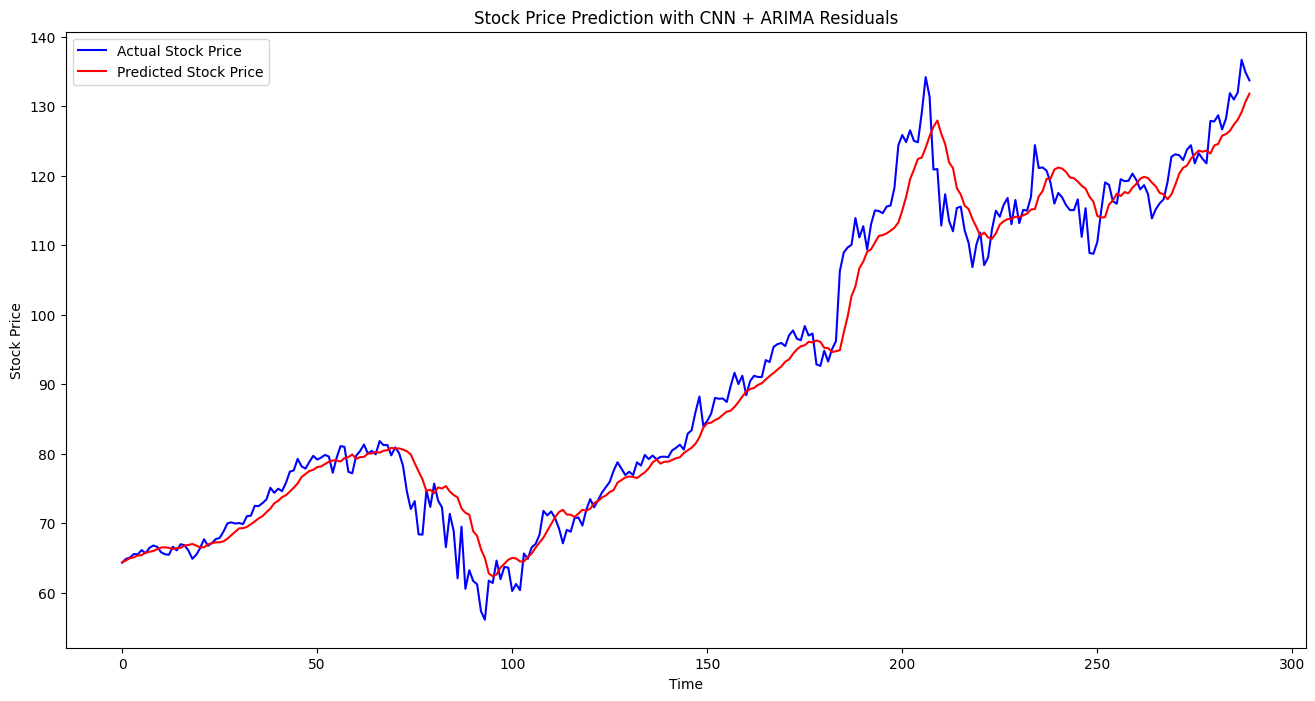


CNN + ARIMA Model Performance:
Training Time: 4.30 seconds
Mean Squared Error: 14.736414549834745
Mean Absolute Error: 2.7881101410964435
R^2 Score: 0.9702640994121954


In [ ]:

# Step 1: Download stock data
def download_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

# Step 2: Data Preprocessing
def preprocess_data(data, is_residuals=False):
    if is_residuals:
        # If the data contains residuals, no need for 'Close' column or scaling
        X, y = [], []
        data_values = data.values  # Extract values from DataFrame
        for i in range(60, len(data_values)):
            X.append(data_values[i-60:i].flatten())  # Use .values to flatten
            y.append(data_values[i])  # Access values directly
        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    else:
        # If the data is stock data
        data = data[['Close']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(data)

        X, y = [], []
        for i in range(60, len(scaled_data)):
            X.append(scaled_data[i-60:i, 0])
            y.append(scaled_data[i, 0])

        X, y = np.array(X), np.array(y)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, y, scaler

    return X, y


# Step 3: Retrain CNN with Residuals as Additional Feature
def build_cnn_with_residuals(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model


# Step 4: XGBoost Model for Residual Prediction
def build_xgboost_model(X_train, y_train):
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
    model.fit(X_train, y_train)
    return model

# Step 5: Combine Residuals into Dataset
def combine_residuals_with_data(X, residuals):
    # Ensure residuals are a 2D array with one column
    if isinstance(residuals, pd.Series):
        residuals = residuals.values
    residuals = residuals.reshape(-1, 1)

    # Flatten X if it has more than 2 dimensions (e.g., from time series data)
    if len(X.shape) == 3:
        # Flatten the last two dimensions or reshape based on the context of your data
        X = X.reshape(X.shape[0], -1)  # Flattening X to 2D

    # Trim the larger array to the smaller array's length
    min_length = min(X.shape[0], residuals.shape[0])
    X = X[:min_length]
    residuals = residuals[:min_length]

    # Concatenate along the last axis (features)
    X_combined = np.concatenate((X, residuals), axis=1)

    return X_combined



# Step 5: Train and Evaluate CNN Model with Residuals

def train_and_evaluate_combined_model(model, X_train, y_train, X_test, y_test, scaler):
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_scaled, predictions)
    mae = mean_absolute_error(y_test_scaled, predictions)
    r2 = r2_score(y_test_scaled, predictions)

    # Plot predictions
    plt.figure(figsize=(16, 8))
    plt.plot(y_test_scaled, color='blue', label='Actual Stock Price')
    plt.plot(predictions, color='red', label='Predicted Stock Price')
    plt.title('Stock Price Prediction with CNN + ARIMA Residuals')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Print model performance
    print("")
    print(f'CNN + ARIMA Model Performance:')
    print(f'Training Time: {training_time:.2f} seconds')
    print(f'Mean Squared Error: {mse}')
    print(f'Mean Absolute Error: {mae}')
    print(f'R^2 Score: {r2}')

    return mse, mae, r2

# Main Execution
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2020-12-31'

# Download and preprocess data
stock_data = download_stock_data(ticker, start_date, end_date)
X, y, scaler = preprocess_data(stock_data)

# Apply ARIMA and get residuals
_, residuals = apply_arima(stock_data)

# Prepare residuals for XGBoost training
residuals_df = pd.DataFrame(residuals, columns=['Residuals'])
X_residuals, y_residuals = preprocess_data(residuals_df, is_residuals=True)

# Train XGBoost model on residuals
xgboost_model = build_xgboost_model(X_residuals.reshape((X_residuals.shape[0], -1)), y_residuals)

# Combine residuals with stock data
X_combined = combine_residuals_with_data(X, residuals)

# Split data into training and test sets
split = int(0.8 * len(X_combined))
X_train_combined, X_test_combined = X_combined[:split], X_combined[split:]
y_train, y_test = y[:split], y[split:]

# If X_train_combined is 2D, reshape it to 3D (samples, features, 1)
if len(X_train_combined.shape) == 2:
    X_train_combined = X_train_combined.reshape(X_train_combined.shape[0], X_train_combined.shape[1], 1)

if len(X_test_combined.shape) == 2:
    X_test_combined = X_test_combined.reshape(X_test_combined.shape[0], X_test_combined.shape[1], 1)

# Now, build the CNN model with the reshaped input
cnn_model_with_residuals = build_cnn_with_residuals((X_train_combined.shape[1], X_train_combined.shape[2]))
mse, mae, r2 = train_and_evaluate_combined_model(cnn_model_with_residuals, X_train_combined, y_train, X_test_combined, y_test, scaler)


CNN + ARIMA performs the best overall, with the lowest MSE and MAE and the highest R² score. It is also the fastest to train.
CNN performs well with a good balance between training time and error metrics but is outperformed by CNN + ARIMA.
CNN-LSTM has the poorest performance in terms of error metrics and R² score, despite similar training time to CNN.
The CNN + ARIMA model is the best choice among the three in terms of both performance and efficiency.
